In [1]:
import numpy as np
import h5py as h5py
import sympy as sy

import matplotlib.pyplot as plt


import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app

from tqdm import tqdm, tqdm_notebook

plt.style.use("ggplot")

/opt/apps/conda/intel-2018.1.163_miniconda/envs/omnia3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# System Definition

In [2]:
# One particle in 3D
system = mm.System()
mass = 1.0 * unit.amu 
system.addParticle(mass)




0

## 3D Double Well Potential

### Y and Z dimensions: Harmonic Well

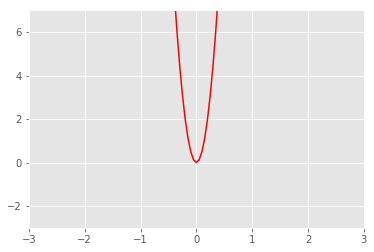

In [3]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-3,7)
plt.xlim(-3,3)
plt.show()

In [4]:
x = sy.symbols('x')
g=sy.diff(0.5*K*x**2,x)
gg=sy.diff(0.5*K*x**2,x,x)
roots_diff=sy.roots(g,x)
roots_yz=list(roots_diff.keys())

In [5]:
# Period:
print("Oscillation periods T in minima:")
for root in roots_diff.keys():
    freq=gg.subs(x,root)
    if freq>0:
        print(2*np.pi*np.sqrt(mass._value/float(freq)))

Oscillation periods T in minima:
0.6283185307179586


### X dimension: Double Well

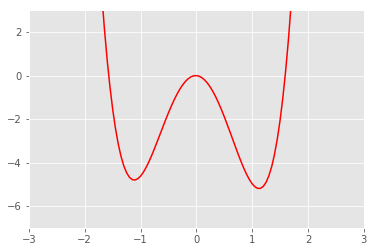

In [6]:
# 'Eo(C*x**4-x**2)+M*x'

def double_well(x,Eo,C,M):
    return Eo*(C*x**4-x**2)+M*x

Eo=8.0
C=0.4
M=-0.175

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-7,3)
plt.xlim(-3,3)
plt.show()

In [7]:
x = sy.symbols('x')
g=sy.diff(Eo*(C*x**4-x**2)+M*x,x)
gg=sy.diff(Eo*(C*x**4-x**2)+M*x,x,x)
roots_diff=sy.roots(g,x)
roots_x=list(roots_diff.keys())

38.4*x**2 - 16.0


In [8]:
# Period:
print("Oscillation periods T in minima:")
for root in list(roots_diff.keys()):
    freq=gg.subs(x,root)
    try:
        if freq>0:
            print(np.sqrt(float(freq)/mass._value))
    except:
        print("Not real frequency found")
        
## Tengo que calcular aqui las dos barreras

Oscillation periods T in minima:
5.6149888971260085
5.698008867629512


## Adding potential to the system

In [11]:
K  = K  * unit.kilocalories_per_mole/unit.angstrom**2
Eo = Eo * unit.kilocalories_per_mole/unit.angstrom**2
C  = C  * 1/unit.angstrom**2
M  = M  * unit.kilocalories_per_mole/unit.angstrom

force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K)
force.addGlobalParameter('Eo', Eo)
force.addGlobalParameter('C', C)
force.addGlobalParameter('M', M)
force.addParticle(0, [])
system.addForce(force)

0

## Initial Conditions

In [12]:
position_minimum=np.array([[roots_x[0],roots_yz[0],roots_yz[0]]],dtype=float)
initial_positions = unit.Quantity(position_minimum, unit.angstroms)
#initial_velocitiies will be randomly generated according to temperature by function:
#context.setVelocitiesToTemperature(temperature)

# Thermodynamic State Definition

In [13]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin

# Simulation Options

In [14]:
step_size       = 0.002*unit.picoseconds
num_steps       = 10000000
saving_period   = 100

friction    = 5/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

## Output arrays and reporters

In [15]:
num_checks     = int(num_steps/saving_period)
times      = unit.Quantity(np.zeros([num_checks], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)

# Context and Initial state of system

In [16]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [17]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Running Simulation

In [18]:
for ii in tqdm(range(num_checks)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

  0%|          | 152/100000 [00:19<3:36:29,  7.69it/s]

KeyboardInterrupt: 

--------------

# Results Analysis

In [19]:
reading =True

if reading:
    h5f = h5py.File('data_double_well_md.h5', 'r')
    #for name in h5f:
    #    print(name)
    times              = h5f['times'][:]
    positions          = h5f['positions'][:]
    velocities         = h5f['velocities'][:]
    kinetic_energies   = h5f['kinetic_energies'][:]
    potential_energies = h5f['potential_energies'][:]
    h5f.close()

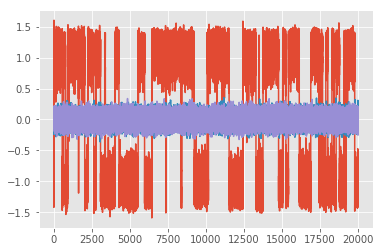

In [20]:
plt.plot(times,positions)

In [21]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)

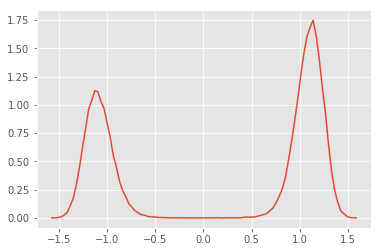

In [22]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)

/opt/apps/conda/intel-2018.1.163_miniconda/envs/omnia3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


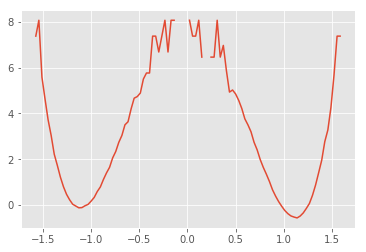

In [23]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))



In [25]:
num_frames  = positions.shape[0]
averages    = np.zeros(num_frames)
std_devs = np.zeros(num_frames)

#for ii in np.arange(num_frames):
#    averages[ii] = np.mean(positions[:(ii+1),0])._value
#    std_devs[ii]  = np.std(positions[:(ii+1),0])._value
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

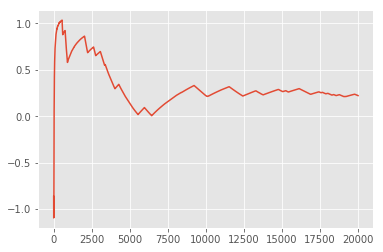

In [26]:
plt.plot(times,averages)

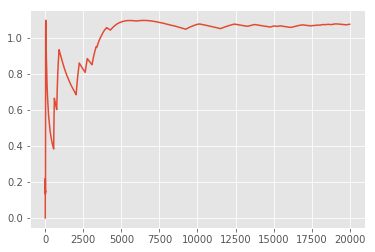

In [27]:
plt.plot(times,std_devs)

In [ ]:
writing = False

if writing: 
    h5f = h5py.File('data_double_well_md.h5', 'w')
    h5f.create_dataset('times', data=times)
    h5f.create_dataset('positions', data=positions)
    h5f.create_dataset('velocities', data=velocities)
    h5f.create_dataset('kinetic_energies', data=kinetic_energies)
    h5f.create_dataset('potential_energies', data=potential_energies)
    h5f.close()

In [ ]:
reading =False

if reading:
    h5f = h5py.File('data_double_well_md.h5', 'r')
    #for name in h5f:
    #    print(name)
    times              = h5f['times'][:]
    positions          = h5f['positions'][:]
    velocities         = h5f['velocities'][:]
    kinetic_energies   = h5f['kinetic_energies'][:]
    potential_energies = h5f['potential_energies'][:]
    h5f.close()

In [ ]:
"""
T = sqrt(m/K)
timestep smaller than ~ T/10
standard deviation in each dimension sigma= (kT / K)^(1/2)
Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT
"""